# All Weather Live Portfolio Tracker

**Start Date**: Set your entry date in Cell 3 (Chicago timezone)  
**Strategy**: v1.2 (Adaptive Rebalancing + Ledoit-Wolf Shrinkage)  
**Rebalance Frequency**: Weekly check (rebalance when drift > 5%)  
**Commission**: 0.3% one-side

---

## Instructions:
1. **Edit Cell 3**: Set your entry date, initial positions, and cash
2. **Run all cells**: See current status, rebalancing needs, and PnL
3. **Check "Rebalancing Analysis"**: See if trades are needed
4. **View PnL Curve**: Track performance from entry to current date
5. **After trading**: Update positions and cash in Cell 3, rerun notebook

**Important**: 
- **All ETFs trade in 100-share lots** (rounded automatically)
- Data fetched live from akshare
- Commission: 0.3% one-side
- PnL tracking updates automatically to latest available data

In [22]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
import pytz
import akshare as ak

from src.optimizer import optimize_weights
from src.utils.reporting import print_section, format_currency

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)

def fetch_etf_prices_akshare(etf_codes, start_date='2015-01-01'):
    """Fetch ETF prices from akshare."""
    all_prices = {}
    
    for code in etf_codes:
        try:
            # Fetch fund data from akshare
            df = ak.fund_etf_hist_em(symbol=code.replace('.SH', ''), 
                                      period="daily", 
                                      start_date=start_date.replace('-', ''), 
                                      adjust="qfq")
            
            # Rename columns and set index
            df['date'] = pd.to_datetime(df['日期'])
            df['close'] = df['收盘']
            df = df.set_index('date')[['close']]
            df.columns = [code]
            
            all_prices[code] = df
            print(f"✓ Fetched {code}: {len(df)} days")
        except Exception as e:
            print(f"✗ Failed to fetch {code}: {e}")
    
    # Combine all ETFs
    if all_prices:
        combined = pd.concat(all_prices.values(), axis=1)
        combined = combined.sort_index()
        return combined
    else:
        raise ValueError("No ETF data fetched successfully")

print("✓ Imports successful")

✓ Imports successful


## 1. Configuration & Initial Position

**EDIT THE NEXT CELL** to set:
- Your entry date (Chicago time)
- Initial positions (shares)
- Initial cash (CNY)

The notebook will fetch live data from akshare and track PnL automatically.

In [23]:
# ========== EDIT YOUR INITIAL POSITIONS HERE ==========
# Initial position as of January 28, 2026 (last trading day in data)
INITIAL_POSITIONS = {
    '510300.SH': 700,      # CSI 300 - Large cap stocks
    '510500.SH': 300,      # CSI 500 - Mid/small cap stocks  
    '513500.SH': 1100,     # S&P 500
    '511260.SH': 100,      # 10Y Treasury (trades in 100s)
    '518880.SH': 300,      # Gold
    '513100.SH': 1100      # Nasdaq-100
}

INITIAL_CASH = 2648  # Remaining cash in CNY
# ======================================================

# Strategy parameters
START_DATE = '2026-01-28'  # Your entry date (Chicago time)
LOOKBACK = 252  # Days for covariance calculation
REBALANCE_THRESHOLD = 0.05  # 5% drift triggers rebalance
COMMISSION_RATE = 0.003  # 0.3% one-side

# Chicago timezone
CHICAGO_TZ = pytz.timezone('America/Chicago')
TODAY_CHICAGO = datetime.now(CHICAGO_TZ)

print(f"Current Time (Chicago): {TODAY_CHICAGO.strftime('%Y-%m-%d %H:%M:%S %Z')}")
print(f"\nInitial Positions (as of {START_DATE}):")
for etf, shares in INITIAL_POSITIONS.items():
    print(f"  {etf}: {shares:,.0f} shares")
print(f"  Cash: {format_currency(INITIAL_CASH)}")

Current Time (Chicago): 2026-02-01 20:57:39 CST

Initial Positions (as of 2026-01-28):
  510300.SH: 700 shares
  510500.SH: 300 shares
  513500.SH: 1,100 shares
  511260.SH: 100 shares
  518880.SH: 300 shares
  513100.SH: 1,100 shares
  Cash: ¥2,648


## 2. Load Live Market Data

Fetching ETF prices from akshare (may take 1-2 minutes)...

In [24]:
# Define ETF universe
ETF_CODES = list(INITIAL_POSITIONS.keys())

# Fetch historical prices from akshare
print("Fetching ETF prices from akshare...")
print("This may take a minute...")
prices = fetch_etf_prices_akshare(ETF_CODES, start_date='2015-01-01')

# Validate and adjust start date if needed
requested_start = pd.Timestamp(START_DATE)
if requested_start not in prices.index:
    # Find the closest date that exists
    if requested_start > prices.index[-1]:
        actual_start = prices.index[-1]
        print(f"\nNote: Requested start date {START_DATE} is beyond data range.")
        print(f"      Using last available date: {actual_start.date()}")
    else:
        # Use the previous available date
        actual_start = prices.index[prices.index <= requested_start][-1]
        print(f"\nNote: Requested date {START_DATE} not in data.")
        print(f"      Using closest previous date: {actual_start.date()}")
    START_DATE = actual_start.strftime('%Y-%m-%d')

# Filter to relevant period (need lookback before start date)
start_idx = prices.index.get_loc(pd.Timestamp(START_DATE))
lookback_start = prices.index[max(0, start_idx - LOOKBACK)]

print(f"\nData loaded: {len(prices)} days")
print(f"Period: {prices.index[0].date()} to {prices.index[-1].date()}")
print(f"Tracking from: {START_DATE}")
print(f"\nLatest prices (as of {prices.index[-1].date()}):")
print(prices.iloc[-1])

Fetching ETF prices from akshare...
This may take a minute...
✓ Fetched 510300.SH: 2695 days
✓ Fetched 510500.SH: 2693 days
✓ Fetched 513500.SH: 2694 days
✓ Fetched 511260.SH: 2049 days
✓ Fetched 518880.SH: 2695 days
✓ Fetched 513100.SH: 2694 days

Data loaded: 2695 days
Period: 2015-01-05 to 2026-02-02
Tracking from: 2026-01-28

Latest prices (as of 2026-02-02):
510300.SH      4.670
510500.SH      8.256
513500.SH      2.410
511260.SH    134.808
518880.SH     10.124
513100.SH      1.862
Name: 2026-02-02 00:00:00, dtype: float64


## 3. Calculate Current Portfolio Status

In [25]:
def calculate_portfolio_value(positions, prices_series, cash=0):
    """Calculate total portfolio value."""
    position_value = sum(
        shares * prices_series.get(etf, 0)
        for etf, shares in positions.items()
    )
    return position_value + cash

def calculate_weights(positions, prices_series, cash=0):
    """Calculate current portfolio weights."""
    total_value = calculate_portfolio_value(positions, prices_series, cash)
    if total_value == 0:
        return {etf: 0.0 for etf in positions.keys()}
    
    weights = {}
    for etf, shares in positions.items():
        position_value = shares * prices_series.get(etf, 0)
        weights[etf] = position_value / total_value
    return weights

# Get latest prices
latest_prices = prices.iloc[-1]

# Current portfolio status
current_value = calculate_portfolio_value(INITIAL_POSITIONS, latest_prices, INITIAL_CASH)
current_weights = calculate_weights(INITIAL_POSITIONS, latest_prices, INITIAL_CASH)

print_section("Current Portfolio Status")
print(f"\nTotal Value: {format_currency(current_value)}")
print(f"Cash: {format_currency(INITIAL_CASH)}")
print(f"Invested: {format_currency(current_value - INITIAL_CASH)}")

print("\nCurrent Weights:")
for etf, weight in sorted(current_weights.items(), key=lambda x: x[1], reverse=True):
    shares = INITIAL_POSITIONS[etf]
    value = shares * latest_prices[etf]
    print(f"  {etf}: {weight:7.2%}  ({shares:>8,.0f} shares, {format_currency(value):>12s})")


CURRENT PORTFOLIO STATUS

Total Value: ¥29,611
Cash: ¥2,648
Invested: ¥26,963

Current Weights:
  511260.SH:  45.53%  (     100 shares,      ¥13,481)
  510300.SH:  11.04%  (     700 shares,       ¥3,269)
  518880.SH:  10.26%  (     300 shares,       ¥3,037)
  513500.SH:   8.95%  (   1,100 shares,       ¥2,651)
  510500.SH:   8.36%  (     300 shares,       ¥2,477)
  513100.SH:   6.92%  (   1,100 shares,       ¥2,048)


## 4. Calculate Target Weights (Risk Parity)

In [26]:
# Get historical returns for covariance calculation
hist_end_idx = prices.index.get_loc(prices.index[-1])
hist_start_idx = max(0, hist_end_idx - LOOKBACK)
hist_returns = prices.iloc[hist_start_idx:hist_end_idx].pct_change().dropna()

print(f"Using {len(hist_returns)} days of returns for optimization")
print(f"Period: {hist_returns.index[0].date()} to {hist_returns.index[-1].date()}")

# Calculate risk parity weights (v1.2 with shrinkage)
target_weights_array = optimize_weights(hist_returns, use_shrinkage=True)
target_weights = dict(zip(prices.columns, target_weights_array))

print_section("Target Weights (Risk Parity v1.2)")
print("\nOptimal allocation:")
for etf, weight in sorted(target_weights.items(), key=lambda x: x[1], reverse=True):
    print(f"  {etf}: {weight:7.2%}")

Using 251 days of returns for optimization
Period: 2025-01-20 to 2026-01-30

TARGET WEIGHTS (RISK PARITY V1.2)

Optimal allocation:
  511260.SH:  43.12%
  518880.SH:  13.89%
  510300.SH:  13.21%
  513500.SH:  10.39%
  510500.SH:  10.33%
  513100.SH:   9.05%


## 5. Calculate Rebalancing Trades

**Note**: All ETFs trade in 100-share lots

In [27]:
def calculate_drift(current_weights, target_weights):
    """Calculate maximum weight drift."""
    max_drift = 0.0
    for etf in current_weights.keys():
        drift = abs(current_weights[etf] - target_weights[etf])
        max_drift = max(max_drift, drift)
    return max_drift

def round_to_lot_size(shares, etf):
    """Round shares to 100-share lots (all ETFs)."""
    # All ETFs trade in 100-share lots
    return round(shares / 100) * 100

def calculate_rebalance_trades(current_positions, target_weights, prices_series, total_value, cash):
    """Calculate required trades to rebalance portfolio."""
    trades = {}
    
    for etf in current_positions.keys():
        target_value = total_value * target_weights[etf]
        target_shares = target_value / prices_series[etf]
        target_shares_rounded = round_to_lot_size(target_shares, etf)
        
        current_shares = current_positions[etf]
        trade_shares = target_shares_rounded - current_shares
        
        if trade_shares != 0:
            trade_value = trade_shares * prices_series[etf]
            commission = abs(trade_value) * COMMISSION_RATE
            
            trades[etf] = {
                'current_shares': current_shares,
                'target_shares': target_shares_rounded,
                'trade_shares': trade_shares,
                'price': prices_series[etf],
                'trade_value': trade_value,
                'commission': commission,
                'side': 'BUY' if trade_shares > 0 else 'SELL'
            }
    
    return trades

# Calculate drift
drift = calculate_drift(current_weights, target_weights)
needs_rebalance = drift > REBALANCE_THRESHOLD

print_section("Rebalancing Analysis")
print(f"\nCurrent Time: {TODAY_CHICAGO.strftime('%Y-%m-%d %H:%M:%S %Z')}")
print(f"Latest Data: {prices.index[-1].date()}")
print(f"\nMaximum drift: {drift:.2%}")
print(f"Rebalance threshold: {REBALANCE_THRESHOLD:.2%}")
print(f"\nNeeds rebalancing: {'YES ✓' if needs_rebalance else 'NO - within threshold'}")

if needs_rebalance:
    trades = calculate_rebalance_trades(
        INITIAL_POSITIONS, 
        target_weights, 
        latest_prices, 
        current_value,
        INITIAL_CASH
    )
    
    if trades:
        print("\n" + "="*70)
        print("REQUIRED TRADES")
        print("="*70)
        
        total_commission = 0
        total_trade_value = 0
        
        for etf, trade in trades.items():
            print(f"\n{etf}:")
            print(f"  Current: {trade['current_shares']:,.0f} shares")
            print(f"  Target:  {trade['target_shares']:,.0f} shares")
            print(f"  Action:  {trade['side']} {abs(trade['trade_shares']):,.0f} shares @ ¥{trade['price']:.4f}")
            print(f"  Value:   {format_currency(abs(trade['trade_value']))}")
            print(f"  Commission: {format_currency(trade['commission'])}")
            
            total_commission += trade['commission']
            total_trade_value += abs(trade['trade_value'])
        
        print(f"\nTotal Trade Value: {format_currency(total_trade_value)}")
        print(f"Total Commission: {format_currency(total_commission)} ({total_commission/total_trade_value*100:.3f}%)")
        
        # Check if we have enough cash
        net_cash_needed = sum(t['trade_value'] for t in trades.values()) + total_commission
        print(f"\nNet Cash Needed: {format_currency(net_cash_needed)}")
        print(f"Available Cash: {format_currency(INITIAL_CASH)}")
        if net_cash_needed > INITIAL_CASH:
            print(f"⚠️  WARNING: Insufficient cash! Need {format_currency(net_cash_needed - INITIAL_CASH)} more")
        else:
            print(f"✓ Sufficient cash available")
    else:
        print("\nNo trades needed (positions already aligned)")
else:
    print("\n✓ Portfolio is within drift threshold. No action needed.")


REBALANCING ANALYSIS

Current Time: 2026-02-01 20:57:39 CST
Latest Data: 2026-02-02

Maximum drift: 3.64%
Rebalance threshold: 5.00%

Needs rebalancing: NO - within threshold

✓ Portfolio is within drift threshold. No action needed.


## 6. PnL Tracking & Visualization

Track performance from entry date to current date with automatic updates


PNL SUMMARY

Entry Date: 2026-01-28
Current Time: 2026-02-01 20:57:39 CST
Latest Data: 2026-02-02

Initial Value (2026-01-28): ¥30,186
Current Value (2026-02-02): ¥29,611

Total PnL: ¥-575 (-1.90%)
Days tracked: 4

Best day: ¥169 (+0.56%) on 2026-01-29
Worst day: ¥-575 (-1.90%) on 2026-02-02
Max Drawdown: -2.45% on 2026-02-02

Recent PnL:
            Portfolio Value    PnL     PnL %
Date                                        
2026-01-28          30185.6    0.0  0.000000
2026-01-29          30354.7  169.1  0.560201
2026-01-30          30011.7 -173.9 -0.576103
2026-02-02          29611.0 -574.6 -1.903557


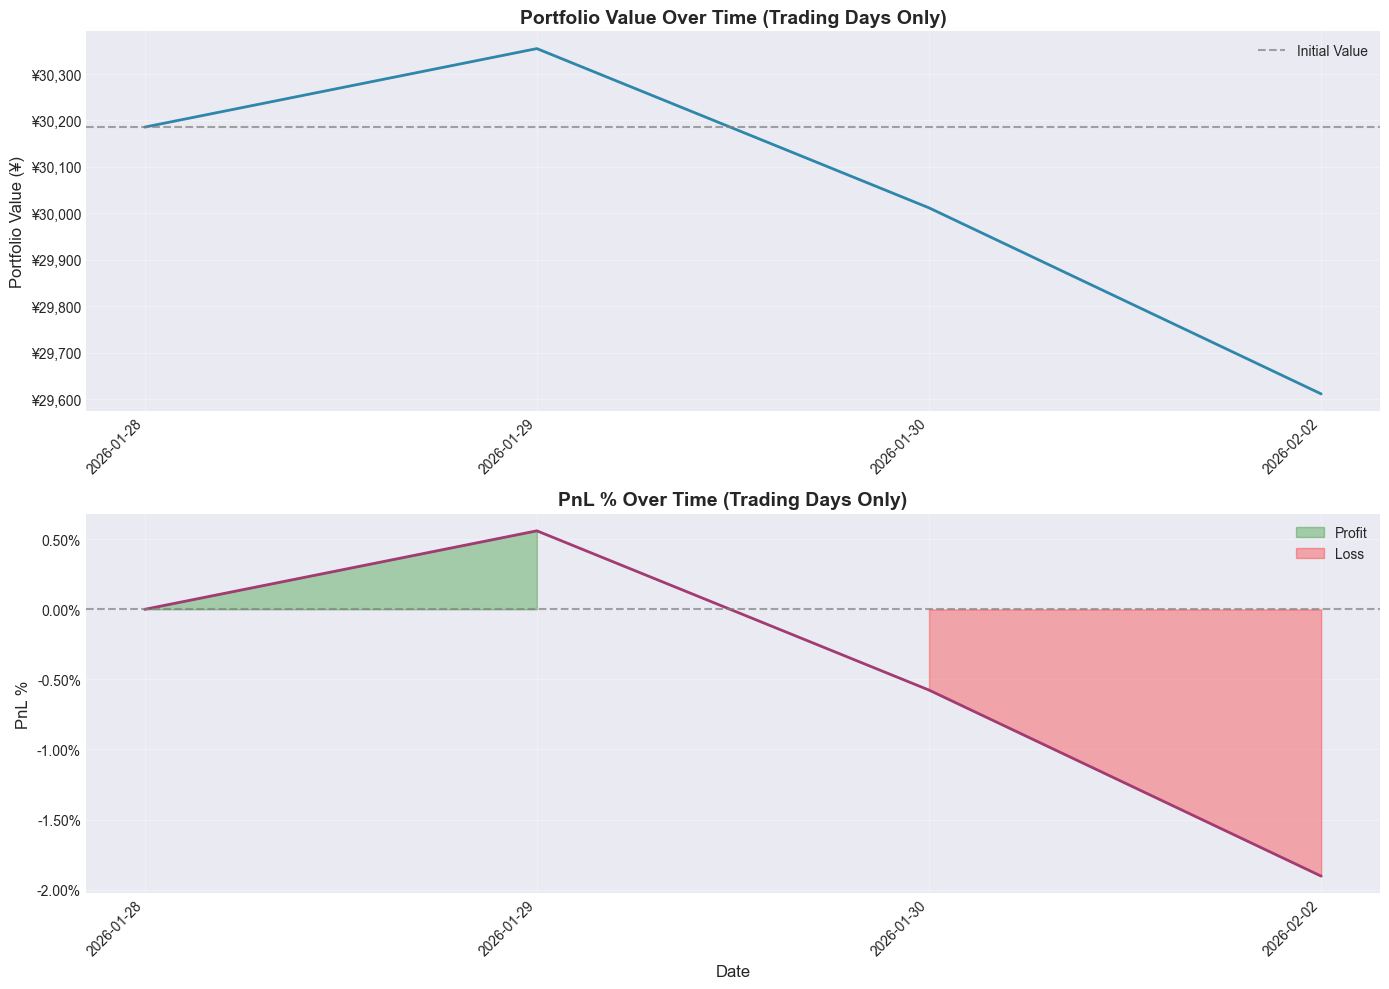

In [28]:
# Calculate daily portfolio values starting from START_DATE
start_date_idx = prices.index.get_loc(pd.Timestamp(START_DATE))
tracking_prices = prices.iloc[start_date_idx:]

# Calculate daily values
daily_values = []
daily_pnl = []

initial_value = calculate_portfolio_value(INITIAL_POSITIONS, prices.loc[START_DATE], INITIAL_CASH)

for date, row in tracking_prices.iterrows():
    daily_value = calculate_portfolio_value(INITIAL_POSITIONS, row, INITIAL_CASH)
    pnl = daily_value - initial_value
    pnl_pct = (pnl / initial_value * 100) if initial_value > 0 else 0
    
    daily_values.append(daily_value)
    daily_pnl.append(pnl)

pnl_df = pd.DataFrame({
    'Date': tracking_prices.index,
    'Portfolio Value': daily_values,
    'PnL': daily_pnl,
    'PnL %': [p / initial_value * 100 if initial_value > 0 else 0 for p in daily_pnl]
}).set_index('Date')

print_section("PnL Summary")
print(f"\nEntry Date: {START_DATE}")
print(f"Current Time: {TODAY_CHICAGO.strftime('%Y-%m-%d %H:%M:%S %Z')}")
print(f"Latest Data: {tracking_prices.index[-1].date()}")
print(f"\nInitial Value ({START_DATE}): {format_currency(initial_value)}")
print(f"Current Value ({tracking_prices.index[-1].date()}): {format_currency(daily_values[-1])}")
print(f"\nTotal PnL: {format_currency(daily_pnl[-1])} ({pnl_df['PnL %'].iloc[-1]:+.2f}%)")
print(f"Days tracked: {len(pnl_df)}")

if len(pnl_df) > 1:
    print(f"\nBest day: {format_currency(pnl_df['PnL'].max())} ({pnl_df['PnL %'].max():+.2f}%) on {pnl_df['PnL'].idxmax().date()}")
    print(f"Worst day: {format_currency(pnl_df['PnL'].min())} ({pnl_df['PnL %'].min():+.2f}%) on {pnl_df['PnL'].idxmin().date()}")
    
    # Calculate max drawdown
    cumulative_max = pnl_df['Portfolio Value'].expanding().max()
    drawdown = (pnl_df['Portfolio Value'] - cumulative_max) / cumulative_max * 100
    max_dd = drawdown.min()
    max_dd_date = drawdown.idxmin()
    print(f"Max Drawdown: {max_dd:.2f}% on {max_dd_date.date()}")

print("\nRecent PnL:")
print(pnl_df.tail(10))

# Plot PnL curve (trading days only, no gaps for weekends/holidays)
if len(pnl_df) > 1:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Use integer x-axis to exclude non-trading days
    x_positions = np.arange(len(pnl_df))
    
    # Portfolio value
    ax1.plot(x_positions, pnl_df['Portfolio Value'].values, linewidth=2, color='#2E86AB')
    ax1.axhline(y=initial_value, color='gray', linestyle='--', alpha=0.7, label='Initial Value')
    ax1.set_title('Portfolio Value Over Time (Trading Days Only)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Portfolio Value (¥)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'¥{x:,.0f}'))
    
    # Set x-axis labels to show dates at regular intervals
    num_ticks = min(10, len(pnl_df))  # Show max 10 date labels
    tick_positions = np.linspace(0, len(pnl_df)-1, num_ticks, dtype=int)
    tick_labels = [pnl_df.index[i].strftime('%Y-%m-%d') for i in tick_positions]
    ax1.set_xticks(tick_positions)
    ax1.set_xticklabels(tick_labels, rotation=45, ha='right')
    
    # PnL percentage
    ax2.plot(x_positions, pnl_df['PnL %'].values, linewidth=2, color='#A23B72')
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
    ax2.fill_between(x_positions, pnl_df['PnL %'].values, 0, 
                     where=pnl_df['PnL %'].values >= 0, alpha=0.3, color='green', label='Profit')
    ax2.fill_between(x_positions, pnl_df['PnL %'].values, 0, 
                     where=pnl_df['PnL %'].values < 0, alpha=0.3, color='red', label='Loss')
    ax2.set_title('PnL % Over Time (Trading Days Only)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('PnL %', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}%'))
    
    # Set x-axis labels for second plot
    ax2.set_xticks(tick_positions)
    ax2.set_xticklabels(tick_labels, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
else:
    print("\n(Need at least 2 days of data to plot PnL curve)")

---

## Next Steps:

1. **If rebalancing needed**: Execute the trades shown in "Required Trades" section
2. **After trading**: Update `INITIAL_POSITIONS` and `INITIAL_CASH` in Cell 3
3. **Rerun notebook**: To see updated status and PnL

**Rebalance Schedule**: Check weekly (every Monday) or when drift > 5%

**Remember**: 
- All ETFs trade in 100-share lots (automatically rounded)
- Commission: 0.3% one-side (included in calculations)
- Data updates automatically from akshare
- PnL tracks from your entry date to latest available data
- Update Cell 3 positions after each trade session